In [119]:
import pandas as pd
from multiprocessing import Pool
import numpy as np

import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['font.family'] = 'Nimbus Sans'
plt.rcParams['font.size'] = 10

color_map = {
    'cnt': 'm',
    'blu': 'b',
    'blv': 'c',
    'grn': 'g',
    'yel': 'y',
    'red': 'r'
}

In [ ]:
cam_ints = pd.read_csv('csvs/camera_intervals.csv', index_col=False)
cam_ints['interval'] = cam_ints['interval'].apply(lambda x: pd.Interval(pd.Timestamp(x.split(', ')[0].strip('[')), 
                                                            pd.Timestamp(x.split(', ')[1].strip(']')), 
                                                            closed='both'))

bombus_visits = pd.read_csv('csvs/bombus_visit_durations.csv', index_col=False, parse_dates=['visit_start', 'visit_end'])
bombus_visits['interval'] = pd.IntervalIndex.from_arrays(bombus_visits['visit_start'], bombus_visits['visit_end'], closed='both')
bombus_visits= bombus_visits[bombus_visits['visit_end']<'2024-07-30']

observed_values = bombus_visits['color'].value_counts()

In [104]:
def run_simulation(cam_ints, bombus_visits):
    visit_dict = {}
    bombus_visits['pi'] = np.random.randint(1, 11, len(bombus_visits))

    color_counts = pd.Series(dtype=int)
    for i, visit in bombus_visits.iterrows():
        pi = visit['pi']
        visit_interval = visit['interval']
        relevant_cams = cam_ints[cam_ints['pi'] == pi]
        assigned = False

        for _, cam in relevant_cams.iterrows():
            cam_interval = cam['interval']
            if visit_interval.overlaps(cam_interval):
                color = cam['color']
                visit_dict[i] = {'visit_start': visit_interval.left, 'pi': pi, 'color': color}
                if color in color_counts:
                    color_counts[color] += 1
                else:
                    color_counts[color] = 1
                assigned = True
        if not assigned:
            visit_dict[i] = {'visit_start': visit_interval.left, 'pi': pi, 'color': 'red'}

    return color_counts, visit_dict

visit_counts, visit_dict = run_simulation(cam_ints, bombus_visits)
print(f'total captured visits: {sum(visit_counts)}')
visit_counts


total captured visits: 255


yel    53
grn    63
cnt    61
blu    45
blv    33
dtype: int64

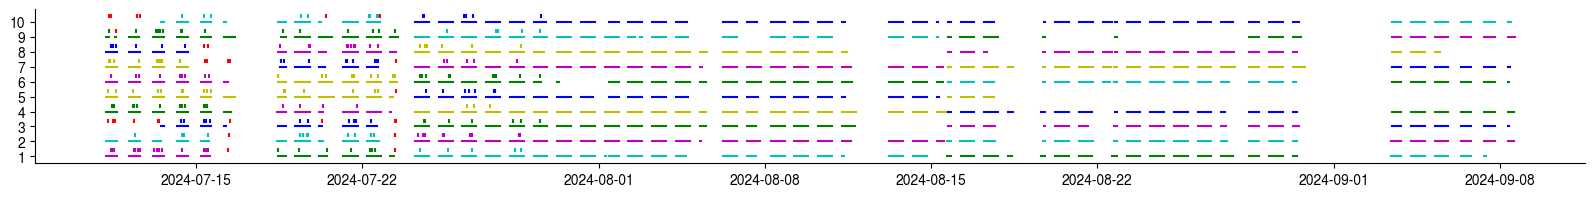

In [105]:
fig, ax = plt.subplots(figsize=(20, 2))
for i, row in cam_ints.iterrows():
    start = row['interval'].left
    end = row['interval'].right
    color = color_map[row['color']]
    pi = row['pi']
    ax.plot([start, end], [pi, pi], color=color)

for key, entry in visit_dict.items():
    visit_start = entry['visit_start']
    pi = entry['pi']
    color = color_map.get(entry['color'])
    ax.scatter(visit_start, pi+.4 , color=color, marker='|', s=10, zorder=3)

ax.set_yticks(np.arange(1,11))
ax.set_yticklabels(np.arange(1,11))
plt.show()

In [106]:
def run_simulation(cam_on, visit_times, iterations=1):
    results = []

    for _ in range(iterations):
        visit_times['pi'] = np.random.randint(1, 11, len(visit_times))
        color_counts = pd.Series(dtype=int)
        for _, visit in visit_times.iterrows():
            pi = visit['pi']
            visit_interval = visit['interval']
            relevant_cams = cam_on[cam_on['pi'] == pi]

            for _, cam in relevant_cams.iterrows():
                cam_interval = cam['interval']
                if visit_interval.overlaps(cam_interval):
                    color = cam['color']
                    color_counts[color] = color_counts.get(color, 0) + 1

        results.append(color_counts)

    final_results = pd.concat(results, axis=1).fillna(0).astype(int).T

    return final_results

# simulation_results = run_simulation(cam_ints, bombus_visits, iterations=1000)

In [107]:
from joblib import Parallel, delayed

def single_simulation(cam_on, visit_times):
    visit_times = visit_times.copy()
    visit_times['pi'] = np.random.randint(1, 11, len(visit_times))
    color_counts = pd.Series(dtype=int)

    for _, visit in visit_times.iterrows():
        pi = visit['pi']
        visit_interval = visit['interval']
        relevant_cams = cam_on[cam_on['pi'] == pi]

        for _, cam in relevant_cams.iterrows():
            cam_interval = cam['interval']
            if visit_interval.overlaps(cam_interval):
                color = cam['color']
                color_counts[color] = color_counts.get(color, 0) + 1

    return color_counts

def run_simulation_parallel(cam_on, visit_times, iterations=1000, num_jobs=20):
    results = Parallel(n_jobs=num_jobs)(
        delayed(single_simulation)(cam_on, visit_times) for _ in range(iterations)
    )

    final_results = pd.concat(results, axis=1).fillna(0).astype(int).T
    return final_results

# simulation_results_parallel = run_simulation_parallel(cam_ints, bombus_visits, iterations=10000)
# simulation_results_parallel.to_csv('simresults_clover_10000_092125.csv', index=False)

## Simulated distributions vs observed counts

In [123]:
df= pd.read_csv('csvs/simresults_clover_10000_092125.csv')

color_map = {
    'cnt': 'm',
    'blu': 'b',
    'blv': 'c',
    'grn': 'g',
    'yel': 'y',
    'red': 'r'
}

name_map = {
    'cnt': 'Contrast + UVF',
    'blu': 'Blue',
    'blv': 'Blue + UVF',
    'grn': 'Green',
    'yel': 'Yellow'
}

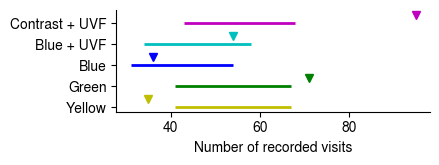

In [124]:
new_order = ['yel', 'grn', 'blu', 'blv', 'cnt']
plt.figure(figsize=(4.5, 1.75))

for i, col in enumerate(new_order):
    data = df[col].dropna()
    min_val, max_val = data.min(), data.max()
    observed = observed_values[col]
    ci_low, ci_high = np.percentile(data, [2.5, 97.5])
    # plt.hlines(y=i, xmin=min_val, xmax=max_val, color=color_map[col], linewidth=1)
    plt.hlines(y=i, xmin=ci_low, xmax=ci_high, color=color_map[col], linewidth=2)
    plt.plot(observed, i + 0.4, marker='v', color=color_map[col], markersize=6)

plt.yticks(ticks=range(len(new_order)), labels=new_order)
mapped_labels = [name_map.get(col, col) for col in new_order]
plt.yticks(ticks=range(len(new_order)), labels=mapped_labels)
plt.xlabel('Number of recorded visits')
# plt.ylabel('Lure color')
plt.tight_layout()
# plt.savefig('figs/simulation_line_interval.png', format='png', dpi=300)
# plt.savefig('figs/simulation_line_interval_clover.svg', format='svg')

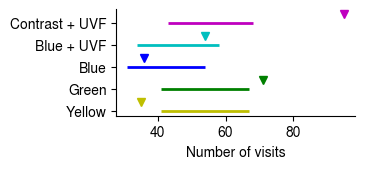

In [126]:
plt.figure(figsize=(3.75, 1.8))

for i, col in enumerate(new_order):
    data = df[col].dropna()
    min_val, max_val = data.min(), data.max()
    observed = observed_values[col]
    ci_low, ci_high = np.percentile(data, [2.5, 97.5])
    # plt.hlines(y=i, xmin=min_val, xmax=max_val, color=color_map[col], linewidth=1)
    plt.hlines(y=i, xmin=ci_low, xmax=ci_high, color=color_map[col], linewidth=2)
    plt.plot(observed, i + 0.4, marker='v', color=color_map[col], markersize=6)

plt.yticks(ticks=range(len(new_order)), labels=new_order)
mapped_labels = [name_map.get(col, col) for col in new_order]
plt.yticks(ticks=range(len(new_order)), labels=mapped_labels)
plt.xlabel('Number of visits')
# plt.ylabel('Lure color')
plt.tight_layout()
# plt.savefig('figs/simulation_line_interval.png', format='png', dpi=300)
# plt.savefig('figs/simulation_interval_clover_small.svg', format='svg')

In [ ]:
p_values = {}

for col in new_order:
    data = df[col].dropna()
    observed = observed_values[col]
    p_val = (np.sum(data >= observed) if observed > np.median(data) 
             else np.sum(data <= observed)) / len(data)
    p_val *= 2 
    p_values[col] = min(p_val, 1.0)

mapped_p_values = {name_map.get(col, col): p for col, p in p_values.items()}

pval_df = pd.DataFrame.from_dict(mapped_p_values, orient='index', columns=['p-value'])
pval_df = pval_df.sort_index()
pval_df

,p-value
Blue,0.2882
Blue + UVF,0.2254
Contrast + UVF,0.0000
Green,0.0150
Yellow,0.0042


In [ ]:
p_values = {}
directions = {}

for col in new_order:
    sim_data = df[col].dropna()
    obs = observed_values[col]
    median = np.median(sim_data)

    if obs > median:
        p = np.sum(sim_data >= obs) / len(sim_data)
    else:
        p = np.sum(sim_data <= obs) / len(sim_data)

    p = min(p * 2, 1.0)
    p_values[col] = p

    directions[col] = "higher" if obs > median else "lower"

results_df = pd.DataFrame({
    'Observed': observed_values,
    'Median of Sim': df.median(),
    'Direction': directions,
    'Two-tailed p-value': p_values
}).loc[new_order]

results_df.index = [name_map.get(c, c) for c in results_df.index]
results_df

,Observed,Median of Sim,Direction,Two-tailed p-value
Yellow,35,54.0,lower,0.0042
Green,71,54.0,higher,0.0150
Blue,36,43.0,lower,0.2882
Blue + UVF,54,46.0,higher,0.2254
Contrast + UVF,95,55.0,higher,0.0000


In [ ]:
from statsmodels.stats.multitest import multipletests

raw_pvals = [p_values[col] for col in new_order]
bonf_reject, bonf_pvals, _, _ = multipletests(raw_pvals, method='bonferroni')
fdr_reject, fdr_pvals, _, _ = multipletests(raw_pvals, method='fdr_bh')

adj_results_df = pd.DataFrame({
    'Observed': [observed_values[col] for col in new_order],
    'Median of Sim': [df[col].median() for col in new_order],
    'Direction': [directions[col] for col in new_order],
    'Raw p-value': raw_pvals,
    'Bonferroni adj p': bonf_pvals,
    'Bonferroni reject (α=0.05)': bonf_reject,
    'FDR adj p': fdr_pvals,
    'FDR reject (α=0.05)': fdr_reject
}, index=[name_map.get(col, col) for col in new_order])

adj_results_df

,Observed,Median of Sim,Direction,Raw p-value,Bonferroni adj p,Bonferroni reject (α=0.05),FDR adj p,FDR reject (α=0.05)
Yellow,35,54.0,lower,0.0042,0.021,True,0.01050,True
Green,71,54.0,higher,0.0150,0.075,False,0.02500,True
Blue,36,43.0,lower,0.2882,1.000,False,0.28820,False
Blue + UVF,54,46.0,higher,0.2254,1.000,False,0.28175,False
Contrast + UVF,95,55.0,higher,0.0000,0.000,True,0.00000,True


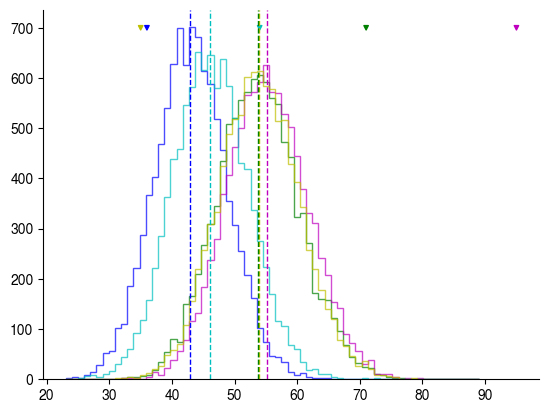

In [125]:
colors = [color_map[col] for col in df.columns]
plt.hist(df.values, bins=df.values.max() - df.values.min()+1, color=colors, histtype='step', alpha=0.7)
for col, color in zip(df.columns, colors):
    plt.axvline(df[col].mean(), color=color, linestyle='dashed', linewidth=1)

plt.scatter(observed_values.values, [700] * len(observed_values), 
           color=[color_map[color] for color in observed_values.index], s=10, marker='v')

plt.show()

In [ ]:
from scipy import stats

sim_means = df.mean()
sim_sds = df.std()
pv_dict = {}

for idx in sim_means.index:
    z_score = (observed_values[idx] - sim_means[idx]) / sim_sds[idx]
    pv = 2 * (1 - stats.norm.cdf(abs(z_score)))  
    pv_dict[idx] = pv

pv_dict


{'yel': 0.004147149398546102,
 'blv': 0.19691091329363353,
 'cnt': 1.6453323148368781e-09,
 'grn': 0.009287611183721456,
 'blu': 0.2485991276471755}

## BLV - BLU simulated vs observed

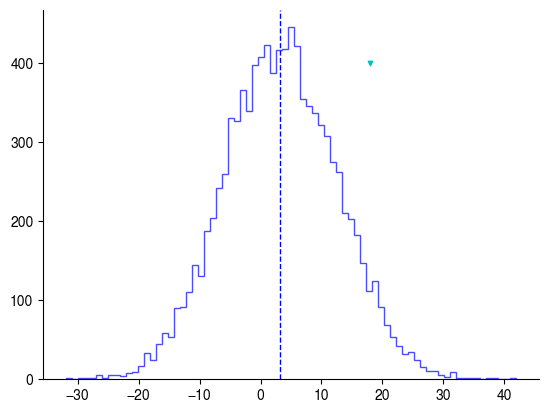

In [ ]:
df['blv-blu'] = df['blv'] - df['blu']

plt.hist(df['blv-blu'], bins=df['blv-blu'].max() - df['blv-blu'].min()+1, color='b', histtype='step', alpha=0.7)
plt.axvline(df['blv-blu'].mean(), color='b', linestyle='dashed', linewidth=1)

plt.scatter(observed_values['blv'] - observed_values['blu'], 400, 
           color='c', s=10, marker='v')


plt.show()

In [ ]:
sim_mean = df['blv-blu'].mean()
sim_sd = df['blv-blu'].std()
observed_value = observed_values['blv'] - observed_values['blu']

z_score = (observed_value - sim_mean) / sim_sd
pv = 1 - stats.norm.cdf(abs(z_score))

print(f'BLV-BLU p-value: {pv}')

BLV-BLU p-value: 0.0578407838980286


## CNT - mean(others)

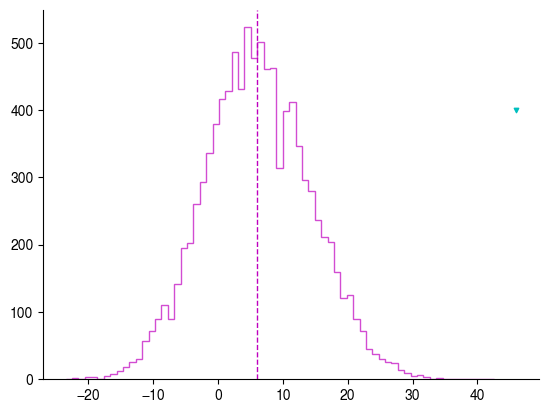

In [ ]:
plt.hist(df['cnt-all'], bins=int(df['cnt-all'].max() - df['cnt-all'].min()+1), color='m', histtype='step', alpha=0.7)
plt.axvline(df['cnt-all'].mean(), color='m', linestyle='dashed', linewidth=1)

plt.scatter(observed_values['cnt'] - observed_values[['blu', 'yel', 'grn', 'blv']].mean(), 400, 
           color='c', s=10, marker='v')


plt.show()